## Modelamiento

In [1]:
# importar librerias
import pandas as pd
import numpy as np
import os
import sys
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
# adicionar directorio src a sys.path
project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
# Ruta datos consolidados
data_path = "C:/Allianz/prueba_allianz/data/processed/allianz_consolidado_imputado.csv"

# Cargar datos consolidados
df_all = pd.read_csv(data_path, sep=";", encoding="utf-8", dtype=str)

from preprocessing import format_columns, clean_text_columns

# Formatea las columnas
df_all = format_columns(df_all)
# Depura textos en columnas
df_all = clean_text_columns(df_all)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684316 entries, 0 to 684315
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   fecha_registro             684316 non-null  object 
 1   comparison_id              684316 non-null  object 
 2   edad                       684316 non-null  int64  
 3   ocupacion                  684316 non-null  object 
 4   tipo_identificacion        684316 non-null  object 
 5   genero                     684316 non-null  object 
 6   fasecolda_id               684316 non-null  object 
 7   marca                      684316 non-null  object 
 8   referencia_vehiculo        684316 non-null  object 
 9   tipo_caja                  684316 non-null  object 
 10  valor_fasecolda            684316 non-null  int64  
 11  modelo                     684316 non-null  int64  
 12  dane_id                    684316 non-null  object 
 13  ciudad                     68

### Manejo de duplicados por valor_prima

In [4]:
bd_allianz_ = df_all.copy()

def remove_inconsistencies(df, key_columns):

    df_clean = df.drop_duplicates(subset=key_columns).copy()
    if 'valor_prima' in df_clean.columns:
        df_clean.drop(columns=['valor_prima'], inplace=True)
    return df_clean.reset_index(drop=True)

def calculate_average_premium(df, key_columns, average_column_name='valor_prima_promedio'):
    averages = df.groupby(key_columns)['valor_prima'].mean().reset_index()
    averages.rename(columns={'valor_prima': average_column_name}, inplace=True)
    return averages


key_columns = ['comparison_id', 'aseguradora_producto', 'perdida_total_cobertura', 'perdida_parcial_deducible']

clean_df = remove_inconsistencies(bd_allianz_, key_columns)
average_df = calculate_average_premium(bd_allianz_, key_columns)
final_df = clean_df.merge(average_df, on=key_columns, how='left')

### Valores atipicos

In [5]:
def detectar_atipicos_por_modelo(df, variable, metodo='iqr', limite=1.5):
    """
    Detecta outliers para una variable numérica segmentando por año de modelo (columna 'modelo').

    Params:
    - df: DataFrame
    - variable: str, nombre de la columna numérica
    - metodo: 'iqr' o 'percentil'
    - limite: float, por defecto 1.5 para IQR o 0.01 para percentil

    Return:
    - df con columna nueva: '{variable}_atipico_modelo'
    """
    df = df.copy()
    col_outlier = f"{variable}_atipico_modelo"
    df[col_outlier] = False

    for anio, sub_df in df.groupby('modelo'):
        valores = sub_df[variable].dropna()

        if metodo == 'iqr':
            Q1 = valores.quantile(0.25)
            Q3 = valores.quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - limite * IQR
            upper = Q3 + limite * IQR
        elif metodo == 'percentil':
            lower = valores.quantile(limite)
            upper = valores.quantile(1 - limite)
        else:
            raise ValueError("Método no reconocido: usa 'iqr' o 'percentil'")

        idx = sub_df[(sub_df[variable] < lower) | (sub_df[variable] > upper)].index
        df.loc[idx, col_outlier] = True

    return df

In [6]:
final_df = detectar_atipicos_por_modelo(final_df, 'valor_prima_promedio')
final_df = detectar_atipicos_por_modelo(final_df, 'valor_fasecolda')
for var in ['valor_prima_promedio', 'valor_fasecolda']:
    col = f"{var}_atipico_modelo"
    total = final_df[col].sum()
    porcentaje = total / len(final_df) * 100
    print(f"📌 {var}: {total:,} atípicos detectados por año de modelo ({porcentaje:.2f}%)")

📌 valor_prima_promedio: 24,015 atípicos detectados por año de modelo (4.70%)
📌 valor_fasecolda: 37,833 atípicos detectados por año de modelo (7.41%)


In [7]:
def boxplot_valor_por_modelo(df, variable='valor_prima_promedio', mostrar_outliers=True, top_n=None):
    """
    Visualiza un boxplot de la variable numérica por año del modelo del vehículo.

    Params:
    - df: DataFrame con datos ya limpios
    - variable: nombre de la variable a graficar
    - mostrar_outliers: bool, si mostrar o no los puntos atípicos
    - top_n: int, opcional, para limitar a los años más frecuentes
    """
    df_plot = df.copy()
    
    # Asegurarse de que modelo es categórico ordenado
    df_plot['modelo'] = df_plot['modelo'].astype(int)
    if top_n:
        top_modelos = df_plot['modelo'].value_counts().sort_index().tail(top_n).index
        df_plot = df_plot[df_plot['modelo'].isin(top_modelos)]

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df_plot, x='modelo', y=variable, showfliers=mostrar_outliers, palette='Set3')
    plt.title(f"📦 Boxplot de {variable.replace('_', ' ').capitalize()} por Año de Modelo")
    plt.xlabel("Modelo (Año)")
    plt.ylabel(variable.replace('_', ' ').capitalize())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

C:\Users\norma\AppData\Local\Temp\ipykernel_6760\1995397668.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='modelo', y=variable, showfliers=mostrar_outliers, palette='Set3')
C:\Users\norma\AppData\Local\Temp\ipykernel_6760\1995397668.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Allianz\prueba_allianz\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


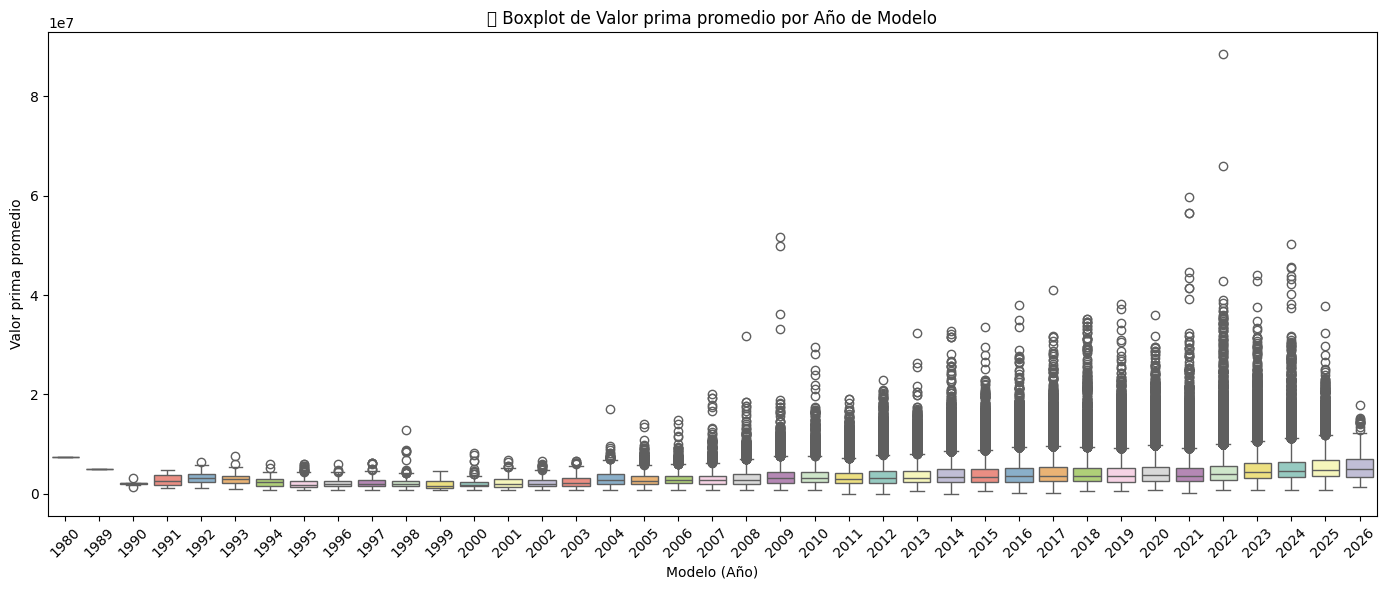

C:\Users\norma\AppData\Local\Temp\ipykernel_6760\1995397668.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='modelo', y=variable, showfliers=mostrar_outliers, palette='Set3')
C:\Users\norma\AppData\Local\Temp\ipykernel_6760\1995397668.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Allianz\prueba_allianz\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


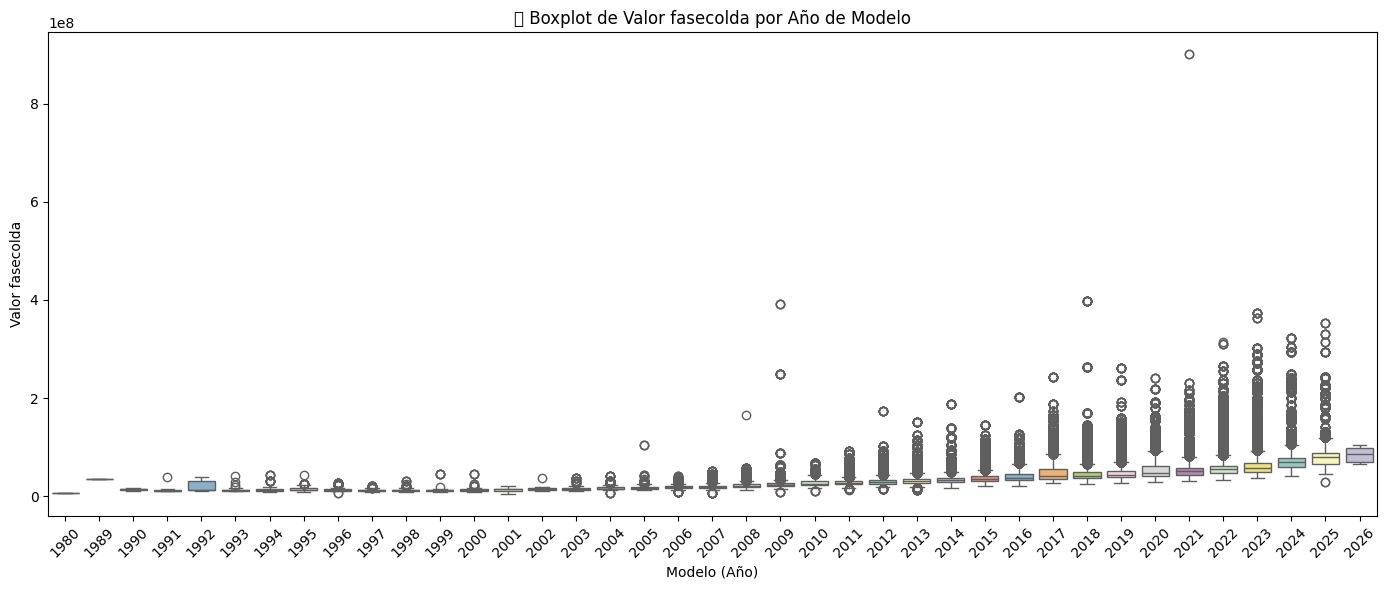

In [8]:
boxplot_valor_por_modelo(final_df, variable='valor_prima_promedio', mostrar_outliers=True)
boxplot_valor_por_modelo(final_df, variable='valor_fasecolda', mostrar_outliers=True)

C:\Users\norma\AppData\Local\Temp\ipykernel_6760\1995397668.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='modelo', y=variable, showfliers=mostrar_outliers, palette='Set3')
C:\Users\norma\AppData\Local\Temp\ipykernel_6760\1995397668.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Allianz\prueba_allianz\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


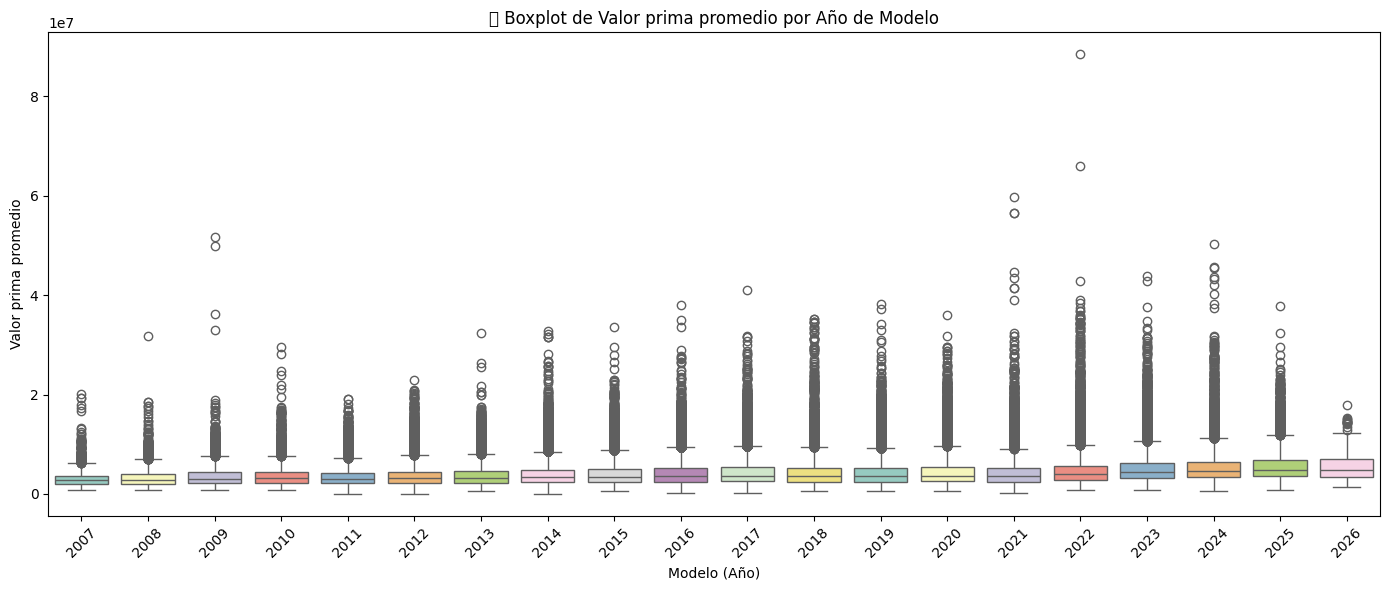

C:\Users\norma\AppData\Local\Temp\ipykernel_6760\1995397668.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='modelo', y=variable, showfliers=mostrar_outliers, palette='Set3')
C:\Users\norma\AppData\Local\Temp\ipykernel_6760\1995397668.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Allianz\prueba_allianz\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


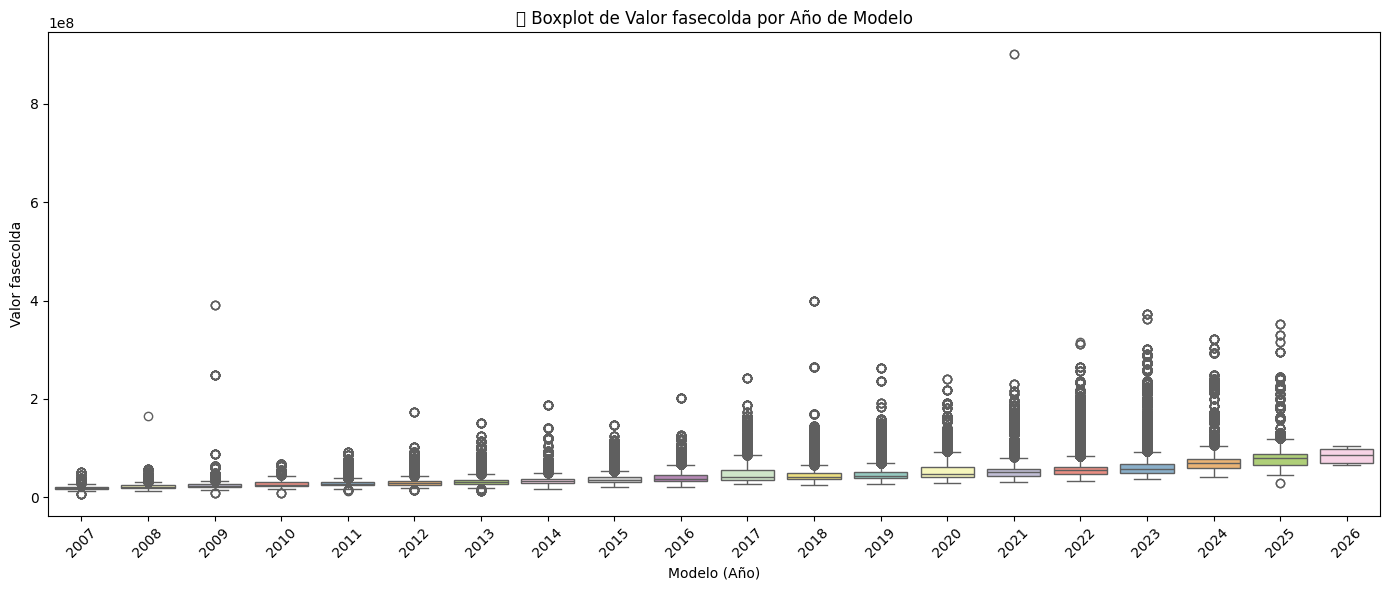

In [9]:
boxplot_valor_por_modelo(final_df, variable='valor_prima_promedio', mostrar_outliers=True, top_n=20)
boxplot_valor_por_modelo(final_df, variable='valor_fasecolda', mostrar_outliers=True, top_n=20)

No se imputan los posibles atipicos debido a la gran variabilidad de marcas y referencias de vehiculos en los ultimos años.

### Reducir categorias de variables saturadas

In [10]:
# Asegurar texto limpio
final_df['referencia_vehiculo'] = final_df['referencia_vehiculo'].astype(str).str.strip().str.upper()

# Crear nueva columna con solo la primera palabra del modelo
final_df['modelo_base'] = final_df['referencia_vehiculo'].str.extract(r'^(\w+)', expand=False)

# eliminar columna referencia_vehiculo
final_df.drop(columns=['referencia_vehiculo'], inplace=True)

# Crear nueva columna con marca y modelo
final_df['marca_modelo'] = (final_df['marca'].str.upper().str.strip() + ' ' + final_df['modelo_base'])

# Eliminar columnas innecesarias
final_df.drop(columns=['marca', 'modelo_base'], inplace=True)

In [11]:
def agrupar_vehiculos_frecuentes(df, top_k=50):
    top_modelos = (
        df['marca_modelo']
        .value_counts()
        .nlargest(top_k)
        .index
    )
    
    df['marca_modelo'] = df['marca_modelo'].apply(
        lambda x: x if x in top_modelos else 'Otros'
    )
    
    return df

In [12]:
final_df = agrupar_vehiculos_frecuentes(final_df, top_k=20)
final_df['marca_modelo'].value_counts()

marca_modelo
Otros              132656
RENAULT SANDERO     34692
RENAULT LOGAN       32626
CHEVROLET SPARK     29035
MAZDA 2             26668
RENAULT STEPWAY     25354
MAZDA 3             24333
CHEVROLET SAIL      23643
SUZUKI SWIFT        21587
CHEVROLET ONIX      19629
KIA PICANTO         19257
FORD FIESTA         17349
RENAULT KWID        15216
VOLKSWAGEN GOL      13773
CHEVROLET AVEO      13735
NISSAN MARCH        13294
KIA RIO             12869
NISSAN VERSA        11194
CHEVROLET BEAT       8334
HYUNDAI ACCENT       7857
CHEVROLET JOY        7665
Name: count, dtype: int64

In [13]:
# modelo
def agrupar_modelo(modelo):
    if modelo >= 2022:
        return 'G1_Muy nuevo (2022+)'
    elif modelo >= 2018:
        return 'G2_Reciente (2018-2021)'
    elif modelo >= 2013:
        return 'G3_Medio (2013-2017)'
    else:
        return 'G4_Antiguo (<=2012)'


def aplicar_grupo_modelo(df, columna_modelo='modelo', nueva_columna='grupo_modelo'):
    df[nueva_columna] = df[columna_modelo].apply(agrupar_modelo)
    return df

In [14]:
# edad
def agrupar_edad(edad):
    if edad < 30:
        return 'G1_18-30'
    elif edad <= 35:
        return 'G2_31-35'
    elif edad <= 40:
        return 'G3_36-40'
    elif edad <= 50:
        return 'G4_41-50'
    elif edad <= 60:
        return 'G5_51-60'
    else:
        return 'G6_60+'

In [15]:
final_df = aplicar_grupo_modelo(final_df)
final_df['grupo_edad'] = final_df['edad'].apply(agrupar_edad)

In [16]:
# ciudad_dpto
ciudades_frecuentes = ['Bogotá D.C. - Bogotá D.C.', 
                        'Medellin - Antioquia',
                        'Cali - Valle del Cauca',
                        'Barranquilla - Atlántico',
                        'Pereira - Risaralda']

# Reemplazar por 'Otros' las ciudades que no están en la lista ciudades_frecuentes
final_df['ciudad_dpto'] = final_df['ciudad_dpto'].where(final_df['ciudad_dpto'].isin(ciudades_frecuentes), 'Otros')
final_df['ciudad_dpto'].value_counts(normalize=True).mul(100).round(2)

ciudad_dpto
Otros                        37.95
Bogotá D.C. - Bogotá D.C.    31.88
Medellin - Antioquia         13.69
Cali - Valle del Cauca       10.38
Barranquilla - Atlántico      4.06
Pereira - Risaralda           2.04
Name: proportion, dtype: float64

In [17]:
final_df.columns

Index(['fecha_registro', 'comparison_id', 'edad', 'ocupacion',
       'tipo_identificacion', 'genero', 'fasecolda_id', 'tipo_caja',
       'valor_fasecolda', 'modelo', 'dane_id', 'ciudad', 'departamento_id',
       'departamento', 'vehiculo_nuevo', 'aseguradora_producto',
       'cotizacion_fecha', 'perdida_total_cobertura',
       'perdida_parcial_deducible', 'rce_limite_unico', 'emitido_producto',
       'emitido_cotizacion', 'source_file', 'delta_minutos', 'anio', 'mes',
       'dia_semana', 'mes_anio', 'aseguradora_origen', 'producto_origen',
       'emitido', 'ciudad_dpto', 'valor_prima_promedio',
       'valor_prima_promedio_atipico_modelo', 'valor_fasecolda_atipico_modelo',
       'marca_modelo', 'grupo_modelo', 'grupo_edad'],
      dtype='object')

In [18]:
final_df['ratio_prima_valor'] = final_df['valor_prima_promedio'] / final_df['valor_fasecolda']

In [19]:
final_df['ocupacion'].value_counts(normalize=True).mul(100).round(2)

ocupacion
Estudiante       82.31
Empleado         14.58
Independiente     1.99
Inversionista     0.45
Pensionado        0.35
Rentista          0.28
Comerciante       0.05
Name: proportion, dtype: float64

In [20]:
def agrupar_ocupacion(df, columna='ocupacion'):
    ocupaciones_conservadas = ['Estudiante', 'Empleado', 'Independiente']
    df[columna] = df[columna].apply(
        lambda x: x if x in ocupaciones_conservadas else 'Otros'
    )
    return df

In [21]:
final_df = agrupar_ocupacion(final_df)
final_df['ocupacion'].value_counts(normalize=True).mul(100).round(2)

ocupacion
Estudiante       82.31
Empleado         14.58
Independiente     1.99
Otros             1.13
Name: proportion, dtype: float64

In [22]:
### Asegurar tipos de variables
id_cols = ['comparison_id', 'fasecolda_id', 'dane_id', 'departamento_id'] 

# Eliminar columnas de id
for col in id_cols:
    if col in final_df.columns:
        final_df.drop(columns=[col], inplace=True)

dates_cols = ['fecha_registro', 'cotizacion_fecha', 'anio', 'mes', 'dia_semana', 'mes_anio', 'source_file']

# Eliminar columnas de fechas
for col in dates_cols:
    if col in final_df.columns:
        final_df.drop(columns=[col], inplace=True)

int_cols = ['edad', 'modelo', 'valor_fasecolda']

# configurar columnas de enteros
for col in int_cols:
    if col in final_df.columns:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce').astype('Int64')

float_cols = ['valor_prima_promedio','ratio_prima_valor']

# configurar columnas de flotantes
for col in float_cols:
    if col in final_df.columns:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce').astype('float32')

cat_cols = ['grupo_modelo', 'grupo_edad', 'ocupacion', 'genero', 'marca', 'referencia_vehiculo',
            'tipo_caja', 'ciudad_dpto', 'vehiculo_nuevo', 'aseguradora_producto',
            'perdida_total_cobertura', 'perdida_parcial_deducible', 'emitido_producto', 
            'aseguradora_origen', 'producto_origen', 'emitido']

# configurar columnas categoricas
for col in cat_cols:
    if col in final_df.columns:
        final_df[col] = final_df[col].astype('object')


bool_cols = ['rce_limite_unico', 'emitido_cotizacion']

# configurar columnas booleanas
for col in bool_cols:
    if col in final_df.columns:
        final_df[col] = final_df[col].astype('bool')

# Eliminar columnas redundantes o innecesarias
final_df.drop(columns=['modelo', 'edad', 'ciudad', 'departamento', 'tipo_identificacion','delta_minutos', 
                       'aseguradora_origen', 'producto_origen', 'emitido_cotizacion'], inplace=True)

In [23]:
# Separar aseguradora_producto
final_df[['aseguradora_origen', 'producto_origen']] = final_df['aseguradora_producto'].str.split('_', n=1, expand=True)
final_df[['aseguradora_emitido', 'producto_emitido']] = final_df['emitido_producto'].str.split('_', n=1, expand=True)
final_df.drop(columns=['aseguradora_producto', 'emitido_producto'], inplace=True)

In [24]:
# Reemplazar valores No en aseguradora_emitido por No_emitido
final_df['aseguradora_emitido'] = final_df['aseguradora_emitido'].replace({'No': 'No_emitido'})
final_df['producto_emitido'] = final_df['producto_emitido'].replace({'emitido': 'No_emitido'})

In [25]:
final_df.drop(columns=['vehiculo_nuevo'], inplace=True)

In [26]:
final_df['producto_origen'].value_counts(normalize=True).mul(100).round(2)

producto_origen
Todo Riesgo Bajo       32.84
Todo Riesgo Alto       17.77
Todo Riesgo Medio      11.53
n/a                     7.48
TodoRiesgoBajo          6.77
Autos Plus              4.72
RCE                     4.62
TodoRiesgoAlto          3.76
Totales                 3.03
TodoRiesgoMedio         2.38
RCE + Totales           1.96
                        1.27
AutosPlus               0.93
Autos Llave en Mano     0.45
RCE+Totales             0.36
AutosLlaveenMano        0.13
Name: proportion, dtype: float64

In [27]:
def estandarizar_producto_origen(valor):
    """
    Limpia y agrupa valores inconsistentes de la columna 'producto_origen'
    para reducir cardinalidad y mejorar la calidad de datos en modelado.
    """
    if pd.isna(valor) or str(valor).strip() == '' or str(valor).lower() == 'n/a':
        return 'No_definido'

    valor = str(valor).lower().replace(" ", "")
    
    if 'todo' in valor and 'riesgo' in valor and 'bajo' in valor:
        return 'TodoRiesgoBajo'
    elif 'todo' in valor and 'riesgo' in valor and 'alto' in valor:
        return 'TodoRiesgoAlto'
    elif 'todo' in valor and 'riesgo' in valor and 'medio' in valor:
        return 'TodoRiesgoMedio'
    elif 'autos' in valor and ('plus' in valor or 'llave' in valor):
        return 'AutosPlus'
    elif 'rce' in valor and 'total' in valor:
        return 'RCE_Totales'
    elif valor == 'rce':
        return 'RCE'
    elif valor == 'totales':
        return 'Totales'
    else:
        return valor.capitalize()

In [28]:
final_df['producto_origen'] = final_df['producto_origen'].apply(estandarizar_producto_origen)
final_df['producto_origen'].value_counts(normalize=True).round(3) * 100

producto_origen
TodoRiesgoBajo     39.6
TodoRiesgoAlto     21.5
TodoRiesgoMedio    13.9
No_definido         8.8
AutosPlus           6.2
RCE                 4.6
Totales             3.0
RCE_Totales         2.3
Name: proportion, dtype: float64

In [29]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510766 entries, 0 to 510765
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ocupacion                            510766 non-null  object 
 1   genero                               510766 non-null  object 
 2   tipo_caja                            510766 non-null  object 
 3   valor_fasecolda                      510766 non-null  Int64  
 4   perdida_total_cobertura              510766 non-null  object 
 5   perdida_parcial_deducible            510766 non-null  object 
 6   rce_limite_unico                     510766 non-null  bool   
 7   emitido                              510766 non-null  object 
 8   ciudad_dpto                          510766 non-null  object 
 9   valor_prima_promedio                 510766 non-null  float32
 10  valor_prima_promedio_atipico_modelo  510766 non-null  bool   
 11  valor_fasecol

In [30]:
def analizar_variables(df):
    
    # 1. Resumen general del DataFrame
    print("RESUMEN GENERAL DEL DATASET")
    print("-" * 50)
    print(f"Número total de registros: {len(df)}")
    print(f"Número de variables: {df.shape[1]}")
    
    # 2. Análisis por tipo de variable
    num_vars = df.select_dtypes(include=['int64', 'float32', 'Int64']).columns
    cat_vars = df.select_dtypes(include=['object']).columns
    bool_vars = df.select_dtypes(include=['bool']).columns
    
    # 3. Variables numéricas
    print("\nANÁLISIS DE VARIABLES NUMÉRICAS")
    print("-" * 50)
    
    if len(num_vars) > 0:
        # Estadísticas descriptivas
        print("\nEstadísticas descriptivas:")
        print(df[num_vars].describe())
        
        # Histogramas y boxplots
        n_num = len(num_vars)
        fig, axes = plt.subplots(n_num, 2, figsize=(15, 5*n_num))
        
        for i, var in enumerate(num_vars):
            # Histograma
            sns.histplot(data=df, x=var, ax=axes[i,0])
            axes[i,0].set_title(f'Distribución de {var}')
            
            # Boxplot
            sns.boxplot(data=df, y=var, ax=axes[i,1])
            axes[i,1].set_title(f'Boxplot de {var}')
        
        plt.tight_layout()
        plt.show()
    
    # 4. Variables categóricas
    print("\nANÁLISIS DE VARIABLES CATEGÓRICAS")
    print("-" * 50)
    
    if len(cat_vars) > 0:
        for var in cat_vars:
            print(f"\nDistribución de {var}:")
            freq = df[var].value_counts()
            pct = df[var].value_counts(normalize=True).mul(100).round(2)
            
            print("\nFrecuencias absolutas y porcentajes:")
            for val, count in freq.items():
                print(f"{val}: {count} ({pct[val]}%)")
            
            # Gráfico de barras
            plt.figure(figsize=(10, 5))
            sns.countplot(data=df, x=var)
            plt.title(f'Distribución de {var}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    
    # 5. Variables booleanas
    print("\nANÁLISIS DE VARIABLES BOOLEANAS")
    print("-" * 50)
    
    if len(bool_vars) > 0:
        fig, axes = plt.subplots(1, len(bool_vars), figsize=(5*len(bool_vars), 5))
        
        if len(bool_vars) == 1:
            axes = [axes]
        
        for ax, var in zip(axes, bool_vars):
            sns.countplot(data=df, x=var, ax=ax)
            ax.set_title(f'Distribución de {var}')
            
            # Añadir porcentajes
            total = len(df[var])
            for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_height()/total)
                x = p.get_x() + p.get_width()/2
                y = p.get_height()
                ax.annotate(percentage, (x, y), ha='center')
        
        plt.tight_layout()
        plt.show()
    
    # 6. Análisis de valores faltantes
    print("\nANÁLISIS DE VALORES FALTANTES")
    print("-" * 50)
    missing = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
    
    missing_df = pd.DataFrame({
        'Valores faltantes': missing,
        'Porcentaje': missing_pct
    })
    print(missing_df[missing_df['Valores faltantes'] > 0])
    
    # 7. Correlaciones entre variables numéricas
    if len(num_vars) > 1:
        print("\nMATRIZ DE CORRELACIÓN")
        print("-" * 50)
        plt.figure(figsize=(10, 8))
        sns.heatmap(df[num_vars].corr(), annot=True, cmap='coolwarm', center=0)
        plt.title('Matriz de correlación de variables numéricas')
        plt.tight_layout()
        plt.show()

In [31]:
# Ejecutar el análisis
#analizar_variables(final_df)

In [32]:
# -------------------------
# 1. PREPROCESAMIENTO
# -------------------------
from scipy import sparse

def preparar_datos_final(df):
    df = df.copy()

    # Asegurar que la variable objetivo sea binaria
    df['emitido'] = df['emitido'].astype(int)

    # Estandarizar producto_origen si existe
    if 'producto_origen' in df.columns:
        df['producto_origen'] = df['producto_origen'].apply(estandarizar_producto_origen)

    # Separar X e y
    X = df.drop(columns=['emitido'])
    y = df['emitido']

    # Variables categóricas y numéricas
    cat_cols = X.select_dtypes(include='object').columns.tolist()
    num_cols = X.select_dtypes(include=['int64', 'float64', 'Int64']).columns.tolist()

    # Codificador
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    X_cat_encoded = encoder.fit_transform(X[cat_cols])

    # Concatenar numéricas con sparse
    X_num = X[num_cols].values  # dense array
    X_final = sparse.hstack([X_cat_encoded, X_num])

    # Split (nota: X_final no puede tener columnas nombradas porque es sparse)
    return train_test_split(X_final, y, test_size=0.3, stratify=y, random_state=42), encoder


In [33]:
# -------------------------
# 2. ENTRENAR Y EVALUAR
# -------------------------
def entrenar_evaluar_modelo(df):
    (X_train, X_test, y_train, y_test), encoder = preparar_datos_final(df)

    modelo = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    # Reporte
    print("\n📊 Reporte de clasificación:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    # ROC AUC
    auc = roc_auc_score(y_test, y_proba)
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"Curva ROC (AUC = {auc:.2f})")
    plt.show()

    return modelo, encoder

In [34]:
final_df.drop(columns=['tipo_caja', 'valor_fasecolda', 'valor_prima_promedio_atipico_modelo', 'valor_fasecolda_atipico_modelo'], inplace=True)

In [35]:
final_df.columns

Index(['ocupacion', 'genero', 'perdida_total_cobertura',
       'perdida_parcial_deducible', 'rce_limite_unico', 'emitido',
       'ciudad_dpto', 'valor_prima_promedio', 'marca_modelo', 'grupo_modelo',
       'grupo_edad', 'ratio_prima_valor', 'aseguradora_origen',
       'producto_origen', 'aseguradora_emitido', 'producto_emitido'],
      dtype='object')

In [36]:
final_df.drop(columns=['aseguradora_origen', 'producto_origen'], inplace=True)

In [38]:
final_df.to_parquet("C:/Allianz/prueba_allianz/data/processed/df_final.parquet", index=False)

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [ ]:
modelo, encoder = entrenar_evaluar_modelo(final_df)

In [ ]:
# -------------------------
# 3. IMPORTANCIA VARIABLES
# -------------------------
def mostrar_importancia_variables(modelo, X_train):
    importancias = pd.Series(modelo.feature_importances_, index=X_train.columns)
    top_vars = importancias.sort_values(ascending=False).head(20)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_vars.values, y=top_vars.index)
    plt.title("🔍 Importancia de Variables en el Modelo")
    plt.xlabel("Importancia")
    plt.ylabel("Variable")
    plt.tight_layout()
    plt.show()
    
    return top_vars


In [ ]:
top_vars = mostrar_importancia_variables(modelo, X_train)

# Observaciones:
# - AUC > 0.80 se considera buen desempeño en clasificación binaria
# - Si la clase "emitido = 1" es desbalanceada (<20%), usar class_weight='balanced'
# - Validar que perfiles con alta probabilidad de emisión tengan sentido comercial y actuarial